Epoch 1/10 - Loss: 0.2945, Val Loss: 0.1633
Epoch 2/10 - Loss: 0.1243, Val Loss: 0.1093
Epoch 3/10 - Loss: 0.0863, Val Loss: 0.1042
Epoch 4/10 - Loss: 0.0656, Val Loss: 0.0926
Epoch 5/10 - Loss: 0.0533, Val Loss: 0.0983
Epoch 6/10 - Loss: 0.0427, Val Loss: 0.1023
Epoch 7/10 - Loss: 0.0358, Val Loss: 0.0998
Epoch 8/10 - Loss: 0.0288, Val Loss: 0.1155
Epoch 9/10 - Loss: 0.0231, Val Loss: 0.1074
Epoch 10/10 - Loss: 0.0192, Val Loss: 0.1103
Test Accuracy: 97.71%


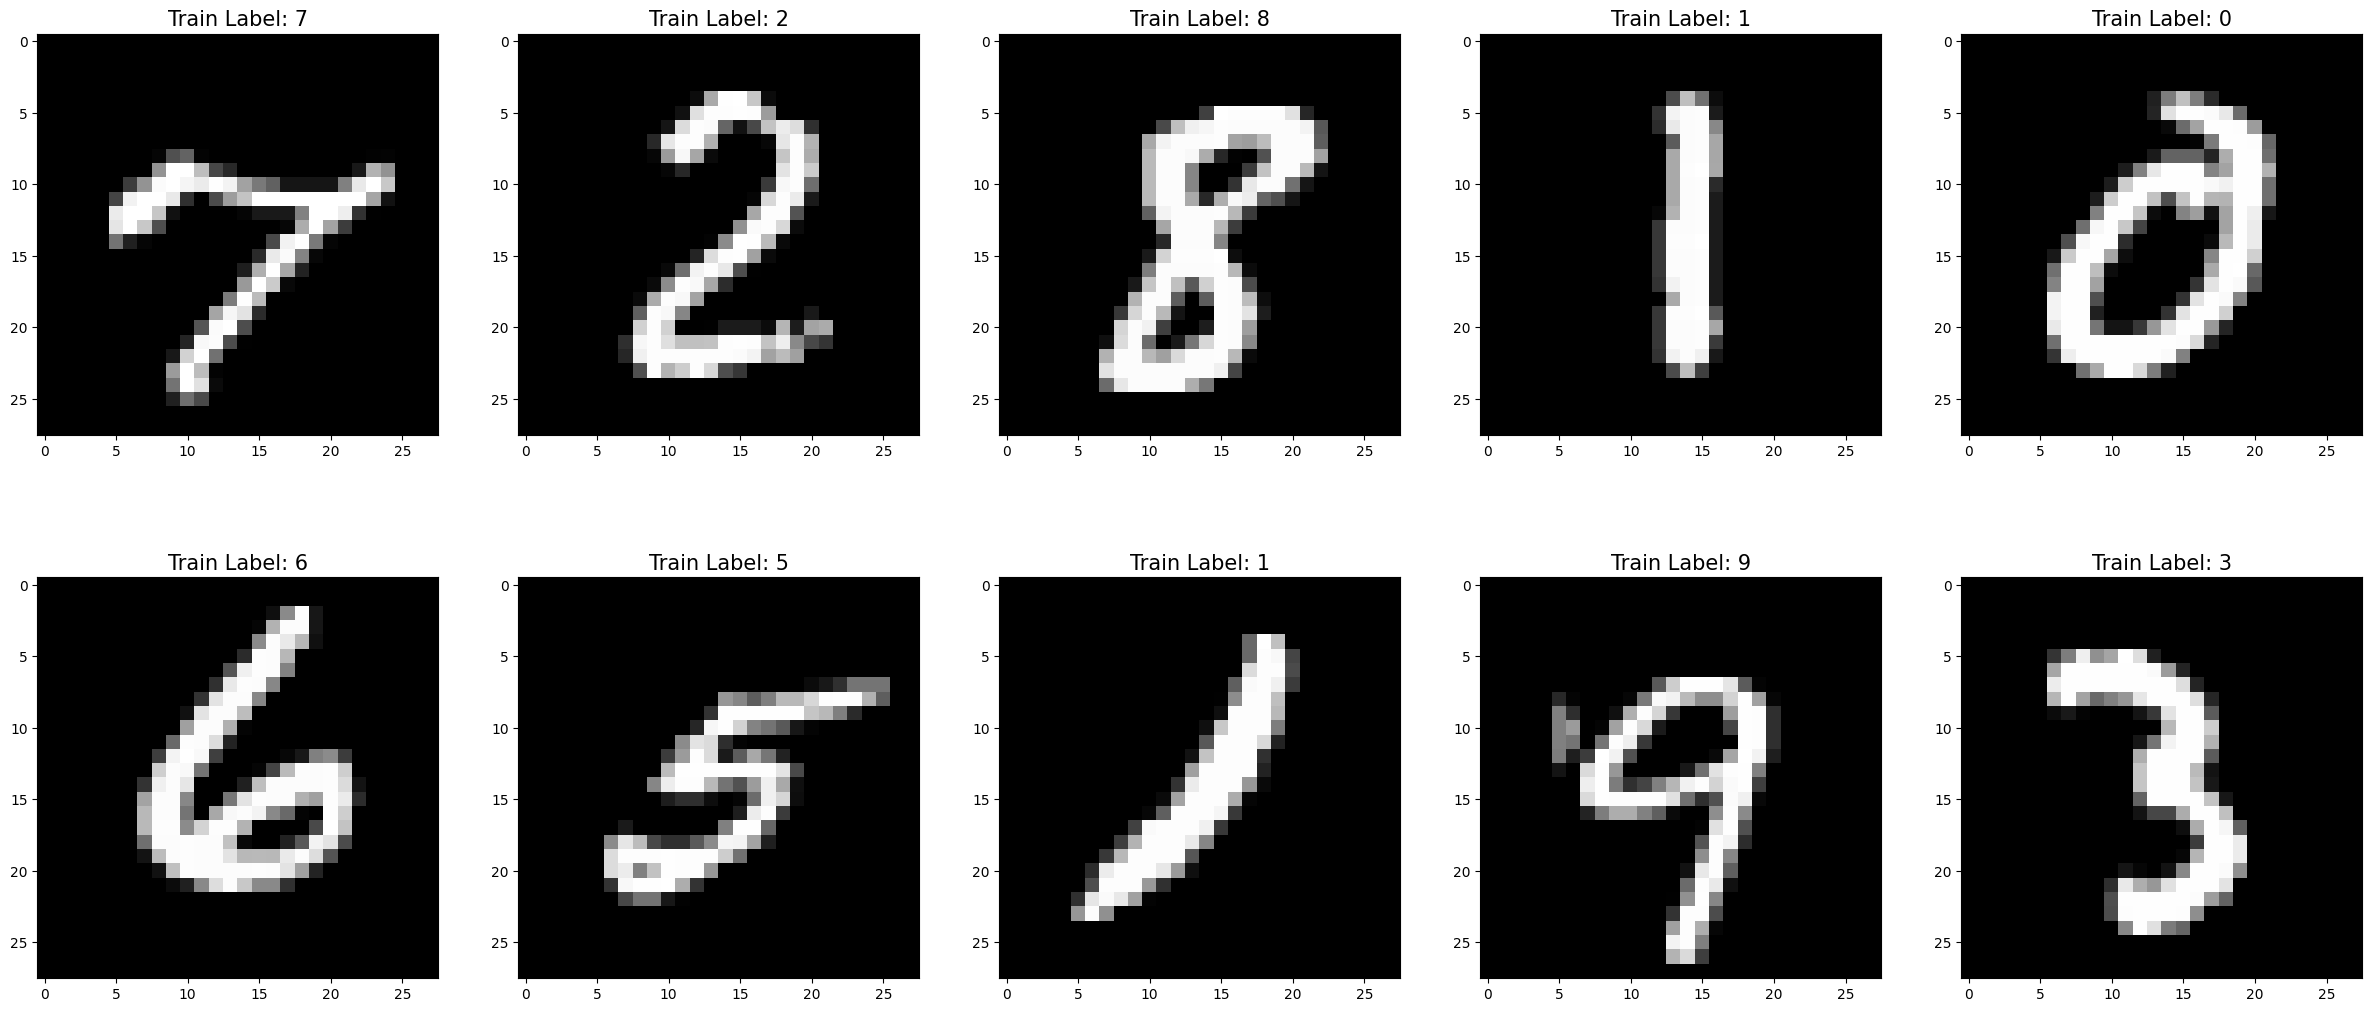

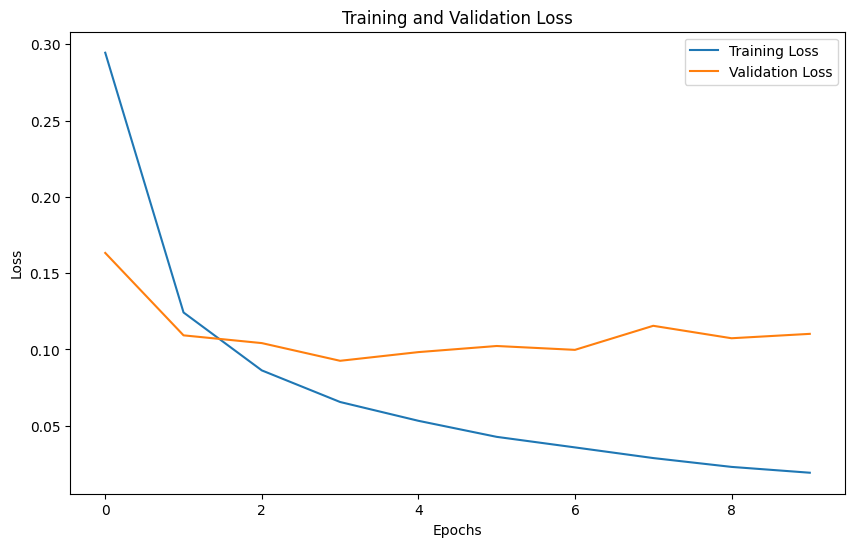

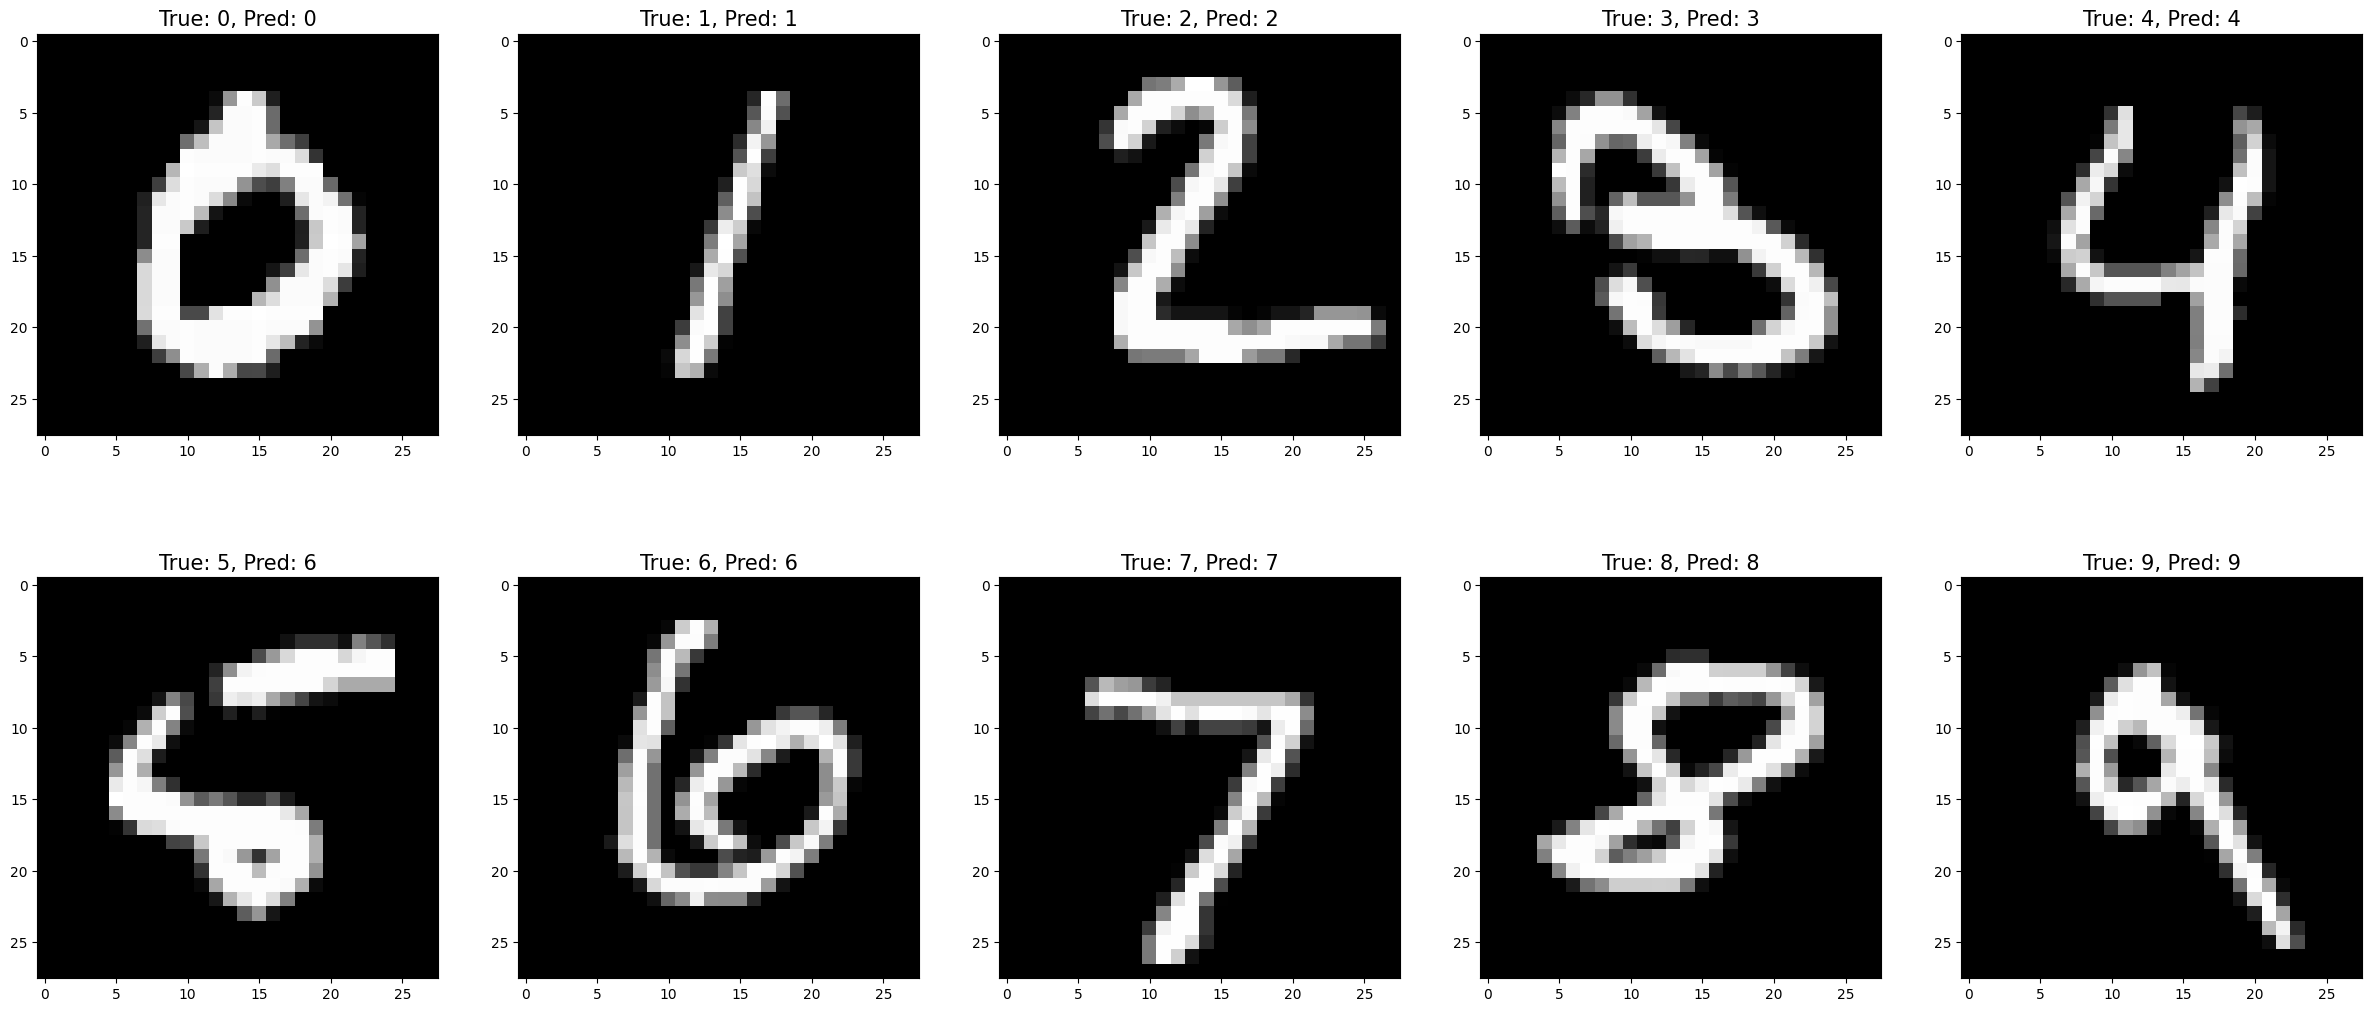

In [ ]:
import numpy as np
import struct
from array import array
import os
import random
import matplotlib.pyplot as plt
from mlp import MultilayerPerceptron, Layer, CrossEntropy, Relu, Softmax, Mish

# -------------------- MNIST Data Loader Class -------------------- #

class MnistDataloader(object):
    """
    A class to load and preprocess the MNIST dataset from IDX files.
    """
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        """
        Reads image and label data from IDX files.
        """
        # Read labels
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))  # Read magic number and size
            if magic != 2049:
                raise ValueError(f'Magic number mismatch, expected 2049, got {magic}')
            labels = array("B", file.read())        
        
        # Read images
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))  # Read metadata
            if magic != 2051:
                raise ValueError(f'Magic number mismatch, expected 2051, got {magic}')
            image_data = array("B", file.read())  # Read pixel data        
        
        # Reshape image data into (size, 28, 28)
        images = [np.array(image_data[i * rows * cols:(i + 1) * rows * cols]).reshape(28, 28) for i in range(size)]
        
        return images, labels
            
    def load_data(self):
        """
        Loads training and test datasets.
        """
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)  

# -------------------- Reading Dataset via MnistDataloader class -------------------- #

data_folder = 'MNIST-data/'  # Dataset directory

# File paths for MNIST dataset
training_images_filepath = os.path.join(data_folder, 'train-images.idx3-ubyte')
training_labels_filepath = os.path.join(data_folder, 'train-labels.idx1-ubyte')
test_images_filepath = os.path.join(data_folder, 't10k-images.idx3-ubyte')
test_labels_filepath = os.path.join(data_folder, 't10k-labels.idx1-ubyte')

# Loading MNIST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Converting lists to NumPy arrays and normalize pixel values
x_train = np.array(x_train).reshape(-1, 784) / 255.0  # Normalize & flatten
x_test = np.array(x_test).reshape(-1, 784) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)

# Manual Train-Validation Split (80% train, 20% validation)
split_idx = int(len(x_train) * 0.8)
x_train, x_val = x_train[:split_idx], x_train[split_idx:]
y_train, y_val = y_train[:split_idx], y_train[split_idx:]

# Function to one-hot encode labels
def one_hot_encode(labels, num_classes=10):
    one_hot = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        one_hot[i][label] = 1
    return one_hot

# Converting labels to one-hot encoding
y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

# Function to display sample images
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(30, 20))
    index = 1
    for img, title in zip(images, title_texts):
        plt.subplot(rows, cols, index)
        plt.imshow(img, cmap=plt.cm.gray)
        plt.title(title, fontsize=15)
        index += 1

# Showing 10 random sample images
sample_indices = random.sample(range(len(x_train)), 10)
images_to_show = [x_train[i].reshape(28, 28) for i in sample_indices]
titles_to_show = [f"Train Label: {np.argmax(y_train[i])}" for i in sample_indices]
show_images(images_to_show, titles_to_show)

# -------------------- MLP Architecture for MNIST Dataset -------------------- #

# Defining a Multi-Layer Perceptron (MLP) model
mlp = MultilayerPerceptron([
    Layer(784, 128, Relu(), dropout_rate=0.0),  # Input layer -> Hidden layer 1 (ReLU activation)
    Layer(128, 64, Relu(), dropout_rate=0.0),   # Hidden layer 1 -> Hidden layer 2 (ReLU activation)
    Layer(64, 10, Softmax())  # Hidden layer 2 -> Output layer (Softmax activation)
])

# Defining loss function
loss_function = CrossEntropy()

# Train the model
train_losses, val_losses = mlp.train(
    x_train, y_train, x_val, y_val,
    loss_function, learning_rate=0.001,
    batch_size=64, epochs=10, optimizer='rmsprop', beta=0.9, epsilon=1e-8
)

# Evaluating model on test set
y_pred = mlp.forward(x_test)
test_accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -------------------- Display Model Predictions -------------------- #

# Selecting one sample per digit class for visualization
samples_to_show = []
titles_to_show = []

for digit in range(10):
    idx = np.where(np.argmax(y_test, axis=1) == digit)[0][0]
    image = x_test[idx].reshape(28, 28)
    predicted_class = np.argmax(mlp.forward(x_test[idx].reshape(1, -1)))
    samples_to_show.append(image)
    titles_to_show.append(f"True: {digit}, Pred: {predicted_class}")

# Displaying selected images with predictions
show_images(samples_to_show, titles_to_show)